# Modelo predictivo para la estimación de casos positivos de influenza en EE.UU.
## Análisis descriptivo

In [36]:
#Importar librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# Cargar los datos
file_path = "./dataset/ICL_NREVSS_Clinical_Labs.csv"

In [39]:
# Leer el CSV ignorando la primera línea
df = pd.read_csv(file_path, skiprows=1)

In [40]:
# Mostrar las primeras filas para entender la estructura
df.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B
0,National,X,2015,40,12029,84,43,1.05578,0.698312,0.357469
1,National,X,2015,41,13111,116,54,1.29662,0.884753,0.411868
2,National,X,2015,42,13441,97,52,1.10855,0.721672,0.386876
3,National,X,2015,43,13537,98,52,1.10807,0.723942,0.384132
4,National,X,2015,44,14687,97,68,1.12344,0.660448,0.462994


In [41]:
# Metadatos del dataset
"""
493 registros, 
12 columnas, 
sin nulos en las columnas.
"""
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   REGION TYPE       493 non-null    object 
 1   REGION            493 non-null    object 
 2   YEAR              493 non-null    int64  
 3   WEEK              493 non-null    int64  
 4   TOTAL SPECIMENS   493 non-null    int64  
 5   TOTAL A           493 non-null    int64  
 6   TOTAL B           493 non-null    int64  
 7   PERCENT POSITIVE  493 non-null    float64
 8   PERCENT A         493 non-null    float64
 9   PERCENT B         493 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 38.6+ KB


In [42]:
"""
Los campos REGION TYPE y REGION tienen
un solo valor único, por lo cual se consideran irrelevantes para el modelo.
"""
# Valores únicos por columna
print("Valores distintos por campo")
print(df.nunique())

# Eliminar columnas irrelevantes
df.drop("REGION TYPE", axis=1, inplace=True)
df.drop("REGION", axis=1, inplace=True)

Valores distintos por campo
REGION TYPE           1
REGION                1
YEAR                 11
WEEK                 53
TOTAL SPECIMENS     493
TOTAL A             394
TOTAL B             331
PERCENT POSITIVE    493
PERCENT A           493
PERCENT B           493
dtype: int64


In [43]:
"""
La intencion inicial es estimar el total
de casos positivos de influenza, por tanto, 
es necesario crear un campo adicional con el total de casos positivos.
"""
# Crear nueva columna TOTAL POSITIVE
df['TOTAL POSITIVE'] = df['TOTAL A'] + df['TOTAL B']

# Generar columna de fecha usando año y semana
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + df['WEEK'].astype(str) + '1', format='%G%V%u')


In [44]:
# Mostrar las primeras filas para revisar los campos agregados
df.head()

,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,TOTAL POSITIVE,DATE
0,2015,40,12029,84,43,1.05578,0.698312,0.357469,127,2015-09-28
1,2015,41,13111,116,54,1.29662,0.884753,0.411868,170,2015-10-05
2,2015,42,13441,97,52,1.10855,0.721672,0.386876,149,2015-10-12
3,2015,43,13537,98,52,1.10807,0.723942,0.384132,150,2015-10-19
4,2015,44,14687,97,68,1.12344,0.660448,0.462994,165,2015-10-26


In [45]:
"""
Al revisar la descripción de los datos, se identifica
que el campo TOTAL POSITIVe tiene una desviación estandar muy elevada.
Por el contrario, el campo PERCENT POSITIVE tiene una desviación estandar menor.
"""
# Descripción de los datos
df.describe().round(2).drop(columns=['DATE'])

,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B,TOTAL POSITIVE
count,493.00,493.00,493.00,493.00,493.00,493.00,493.00,493.00,493.00
mean,2019.98,26.61,46406.45,3544.42,856.77,6.36,4.67,1.69,4401.19
min,2015.00,1.00,5247.00,3.00,3.00,0.05,0.01,0.02,8.00
25%,2018.00,13.00,16223.00,94.00,41.00,0.90,0.56,0.11,165.00
50%,2020.00,27.00,35938.00,346.00,119.00,2.17,1.28,0.50,564.00
75%,2022.00,40.00,64502.00,3647.00,479.00,9.55,6.05,1.65,5003.00
max,2025.00,53.00,191785.00,53042.00,11264.00,31.67,30.46,17.59,55940.00
std,2.75,15.35,38179.07,7571.66,1811.63,8.12,6.64,2.84,8379.88


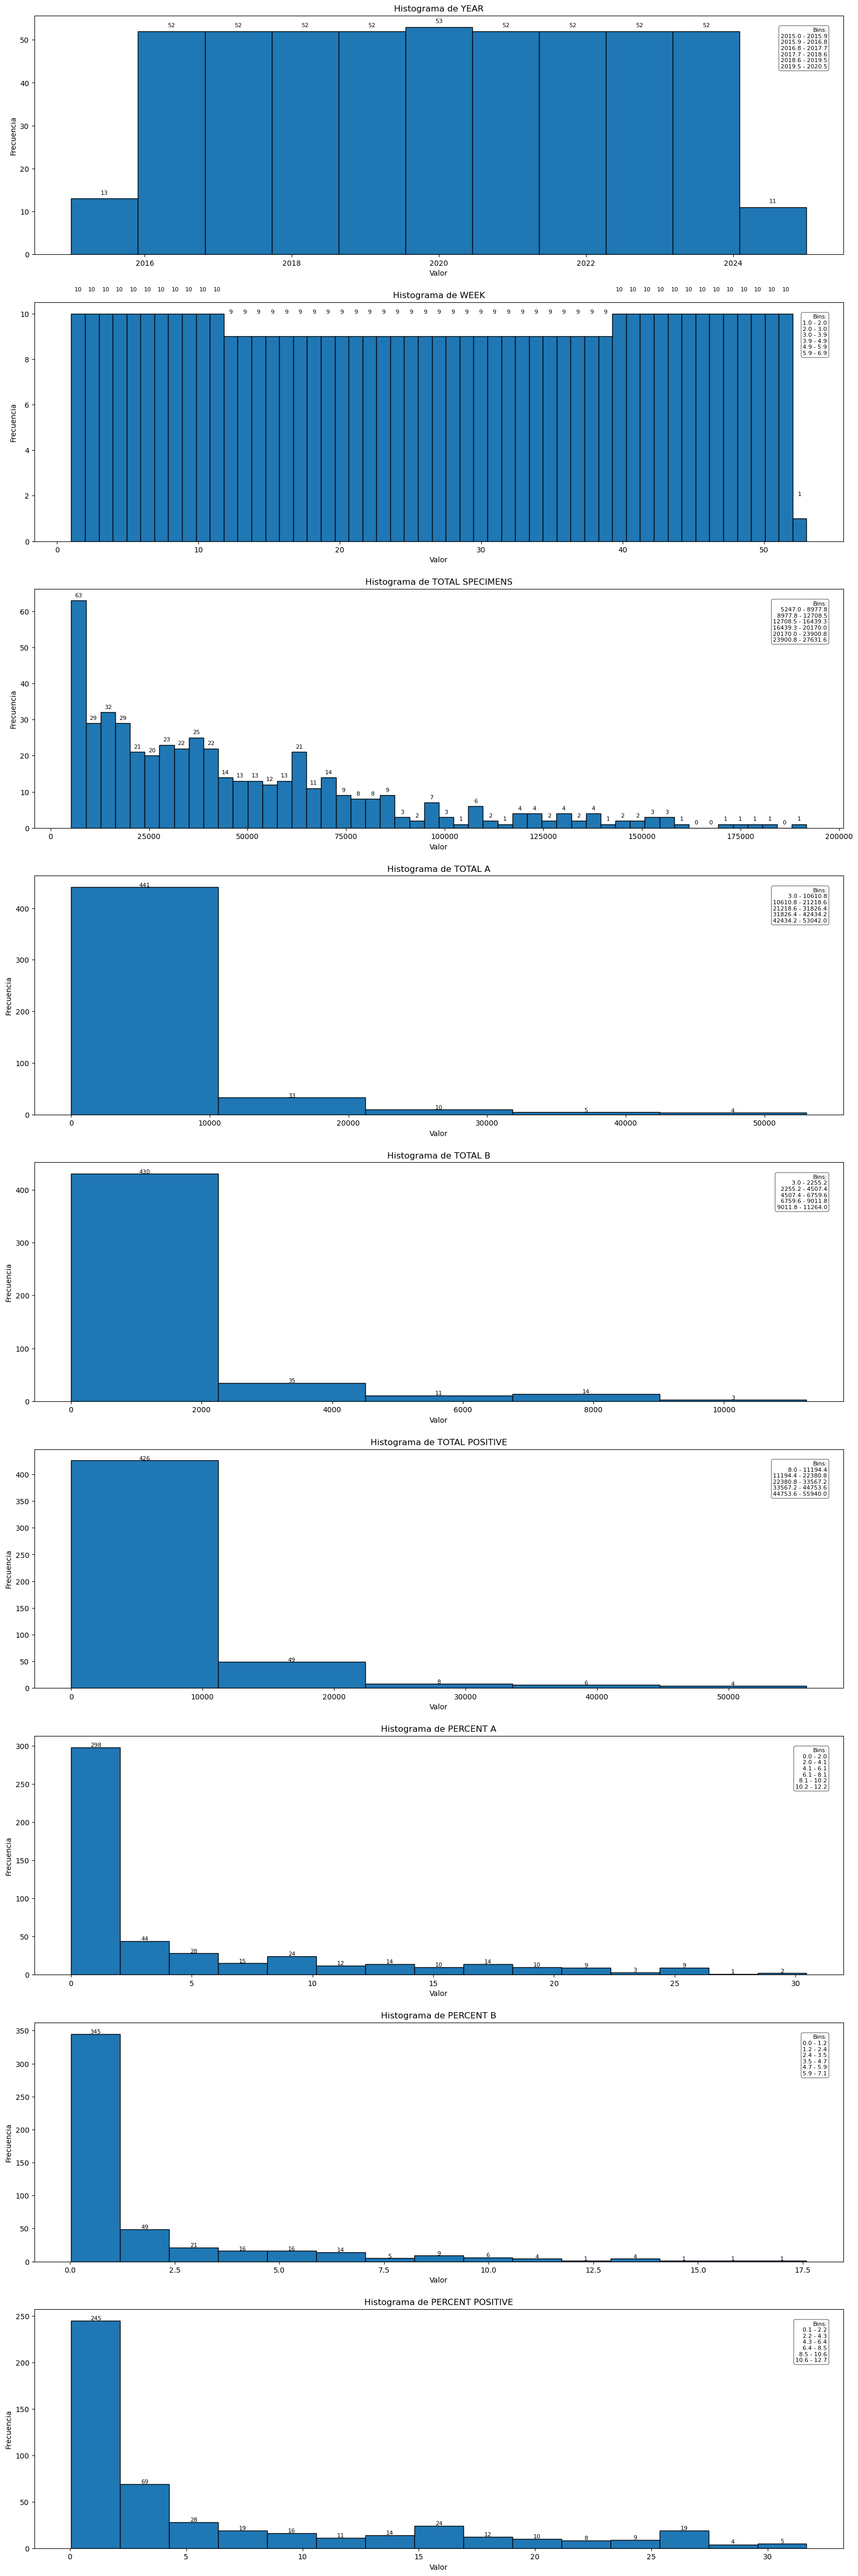

In [46]:
"""
Year - Los años 2015 y 2025 están incompletos. Todos los otros años tienen 52 semanas, excepto el 2020 que tiene 53 por ser viciesto.
Week - Los que tienen 9 semanas es porque no se incluyen en 2015 y 2025. Los que tienen 10 semanas no incluyen el año 2015 o 2025. El año 2015 tiene solo las ultimas 13 seamanas y el 2025 las primeras 11 semanas.

Se observa que la distribucion de los datos se encuentra sesgada a la izquierda para todos los campos numericos.
"""

# Columnas a graficar
columnas = ["YEAR", "WEEK","TOTAL SPECIMENS","TOTAL A","TOTAL B","TOTAL POSITIVE","PERCENT A","PERCENT B","PERCENT POSITIVE"]

# Bins para cada histograma
bins_dict = {
    "YEAR": 11,  
    "WEEK": 53,
    "TOTAL SPECIMENS": 50,
    "TOTAL A": 5,
    "TOTAL B": 5,
    "TOTAL POSITIVE": 5,
    "PERCENT A": 15,
    "PERCENT B": 15,
    "PERCENT POSITIVE": 15
}

# Crear figura
n = len(columnas)
plt.figure(figsize=(20, 7 * n))

for i, col in enumerate(columnas):
    plt.subplot(n, 1, i + 1)

    bins = bins_dict.get(col, 20)
    counts, bin_edges, patches = plt.hist(df[col], bins=bins, edgecolor='black')

    # Etiquetas sobre las barras
    for count, patch in zip(counts, patches):
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        plt.text(x, y + 1, str(int(count)), ha='center', fontsize=8)

    # Agregar texto con los rangos de bins
    bin_labels = [f"{bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}" for i in range(len(bin_edges)-1)]
    bins_text = "\n".join(bin_labels[:6])  # mostrar solo los primeros 6 para que no sea kilombo
    plt.text(0.98, 0.95, f"Bins:\n{bins_text}", ha='right', va='top',
             transform=plt.gca().transAxes, fontsize=8, bbox=dict(boxstyle="round", fc="white", ec="gray"))
    
    plt.title(f"Histograma de {col}")
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")

<Axes: xlabel='PERCENT POSITIVE'>

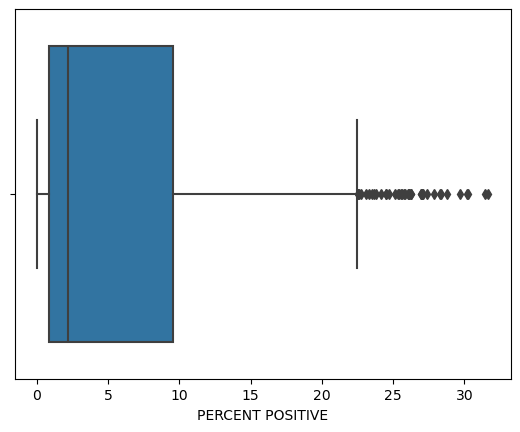

In [47]:
"""
Al evaluar la variable de interés, PERCENT POSITIVE, se identifican valores atípicos en los datos.
"""
sns.boxplot(x=df['PERCENT POSITIVE'])

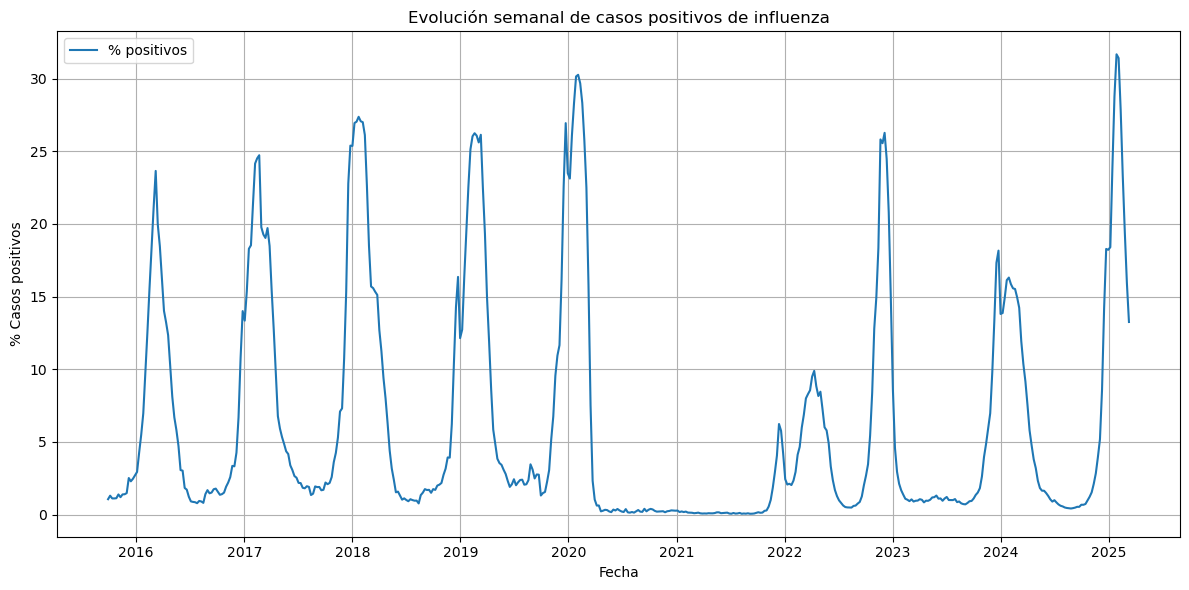

In [48]:
"""
Al verificar el comportamiento de los datos a través del tiempo, se identifica un comportamiento cíclico,
con una interrupción abrupta en el año 2021.
"""
plt.figure(figsize=(12, 6))
plt.plot(df['DATE'], df['PERCENT POSITIVE'], label='% positivos')
plt.xlabel("Fecha")
plt.ylabel("% Casos positivos")
plt.title("Evolución semanal de casos positivos de influenza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
"""
En función de la interrupción abrupta del 2021, se determina tomar una muestra de los datos
a partir del año 2022.
"""
filtered_df = df[df["YEAR"] > 2021][['DATE','PERCENT POSITIVE']]

In [50]:
# Mostrar las primeras filas de los datos filtrados
filtered_df.head()

,DATE,PERCENT POSITIVE
326,2022-01-03,2.43518
327,2022-01-10,2.06453
328,2022-01-17,2.11855
329,2022-01-24,2.02929
330,2022-01-31,2.33841


In [51]:
"""
Se observa que la desviación estandar del campo PERCENT POSITIVE disminuyó un poco.
Quedan 167 registros en la muestra.
"""
# Descripción de los datos
filtered_df.describe().round(2).drop(columns=['DATE'])

,PERCENT POSITIVE
count,167.00
mean,6.20
min,0.42
25%,0.96
50%,2.12
75%,8.72
max,31.67
std,7.55


<Axes: xlabel='PERCENT POSITIVE'>

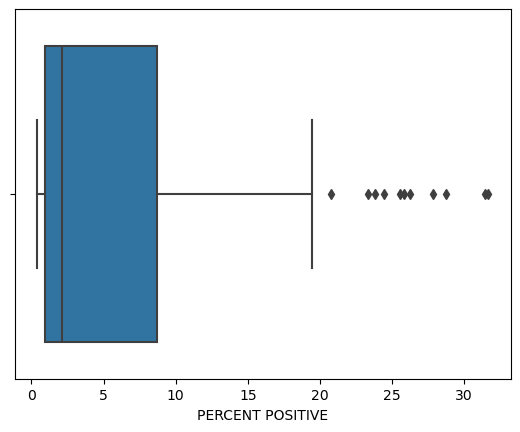

In [52]:
"""
Al revisar la distribución de PERCENT POSITIVE, se identifica
que los datos siguen sesgados a la izquierda, y se mantienen valores atípicos, aunque en menos cantidad.
"""
sns.boxplot(x=filtered_df['PERCENT POSITIVE'])

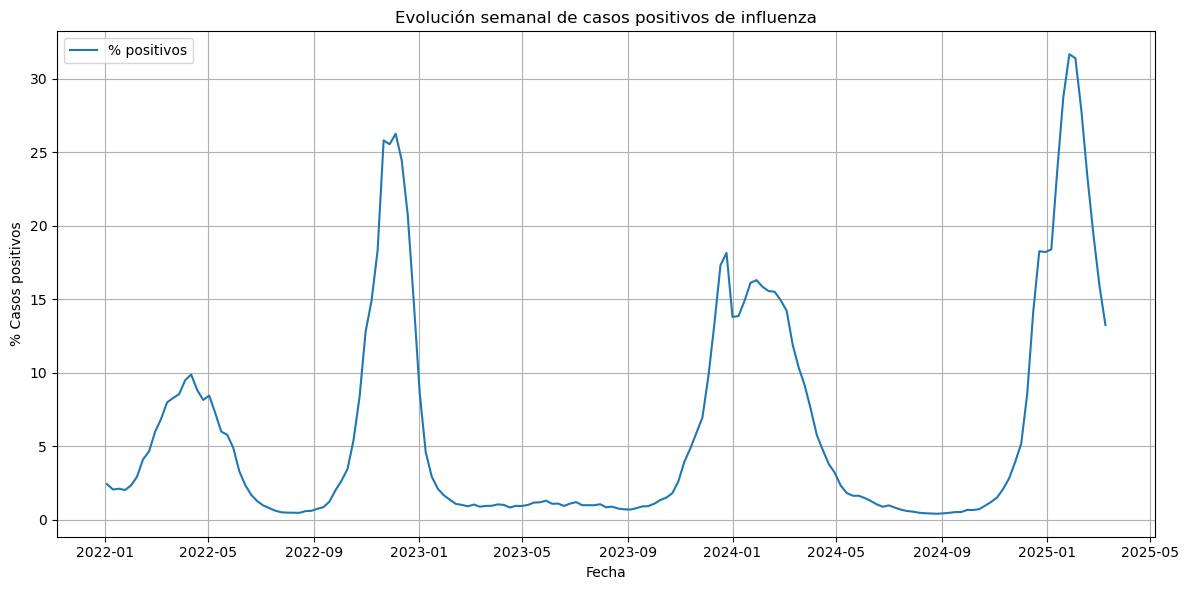

In [53]:
"""
Al revisar el comportamiento de los datos en la linea de tiempo, se identifica mayor consistencia que al conservar el año 2021.
"""
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['DATE'], filtered_df['PERCENT POSITIVE'], label='% positivos')
plt.xlabel("Fecha")
plt.ylabel("% Casos positivos")
plt.title("Evolución semanal de casos positivos de influenza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
"""
Se evalúa si reducir los periodos a mes-año mejora la distribución, los valores atípicos y el error.
"""
grouped_df = filtered_df
grouped_df["DATE_TRUNC"] = grouped_df["DATE"].dt.to_period("M").dt.to_timestamp()
grouped_df = grouped_df[['DATE_TRUNC','PERCENT POSITIVE']]

grouped_df = grouped_df.groupby("DATE_TRUNC").sum()
grouped_df.reset_index(inplace=True)

grouped_df.head()

,DATE_TRUNC,PERCENT POSITIVE
0,2022-01-01,10.98596
1,2022-02-01,17.68922
2,2022-03-01,31.70601
3,2022-04-01,36.37504
4,2022-05-01,32.41884


In [59]:
"""
Se identifica que la desviación estandar aumenta al agrupar los datos por periodos de año-mes
"""
# Descripción de los datos
grouped_df.describe().round(2).drop(columns=['DATE_TRUNC'])

,PERCENT POSITIVE
count,39.00
mean,26.53
min,1.79
25%,4.06
50%,10.42
75%,34.56
max,102.66
std,30.37


<Axes: xlabel='PERCENT POSITIVE'>

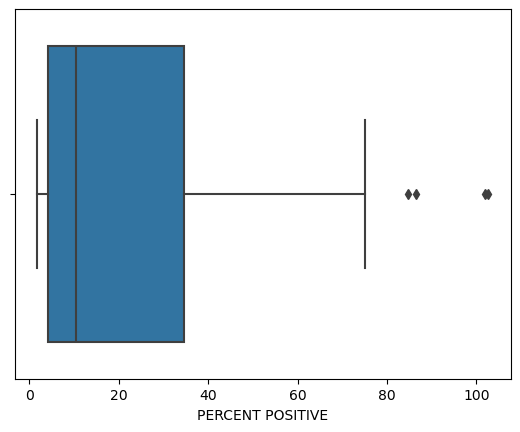

In [60]:
"""
Para los datos agrupados, hay menos valores atípicos que en los datos solo filtrados hasta 2021, pero el sesgo a la izquierda se mantiene.
"""
sns.boxplot(x=grouped_df['PERCENT POSITIVE'])

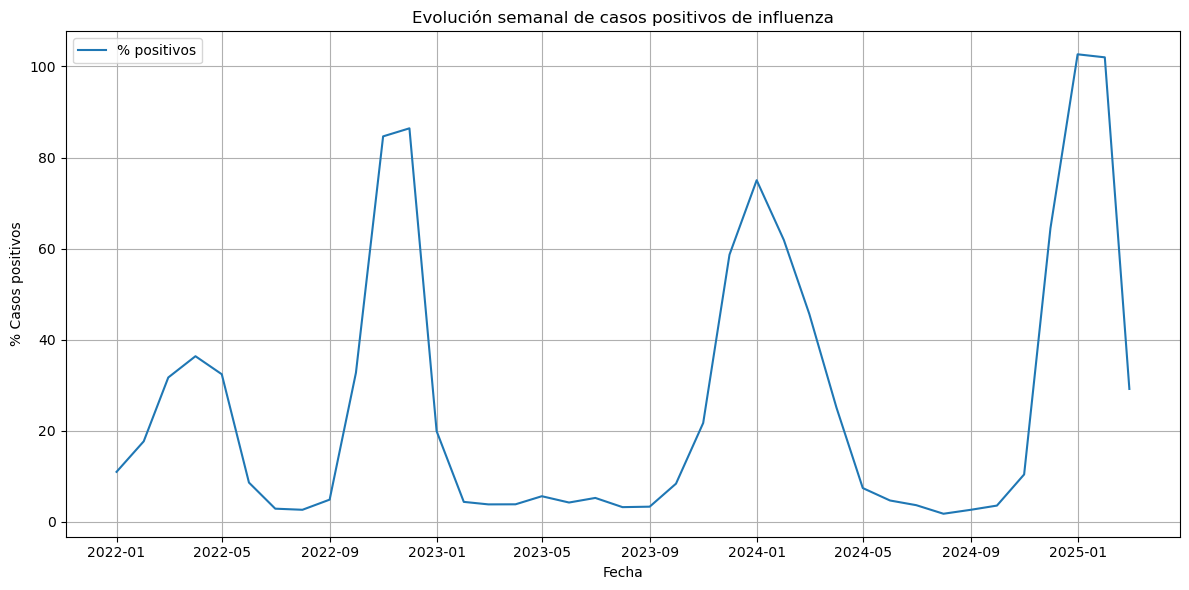

In [61]:
"""
Al revisar el comportamiento de los datos en la linea de tiempo, se observa que los picos de la linea están más marcados.
"""
plt.figure(figsize=(12, 6))
plt.plot(grouped_df['DATE_TRUNC'], grouped_df['PERCENT POSITIVE'], label='% positivos')
plt.xlabel("Fecha")
plt.ylabel("% Casos positivos")
plt.title("Evolución semanal de casos positivos de influenza")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluación de correlación para datos filtrados (filtered_df) y datos filtrados + agrupados (grouped_df)

In [62]:
import numpy as np
from statsmodels.tsa.stattools import acf

### Correlación de PERCENT POSITIVE para datos filtrados (filtered_df)

In [63]:
f_serie = filtered_df['PERCENT POSITIVE'].values
f_n = len(f_serie)
print(f_n)

167


In [64]:
# Calcular autocorrelaciones para los primeros 20 retrasos
max_lag = 20
f_rk_values = acf(f_serie, nlags=max_lag, fft=False)
print(f_rk_values)

[ 1.          0.96954644  0.8979879   0.80008844  0.6849325   0.55907868
  0.42860929  0.30274003  0.18807542  0.08897892  0.00626213 -0.06481349
 -0.12554401 -0.17410485 -0.2113993  -0.24057036 -0.26430163 -0.28258894
 -0.29576171 -0.30502029 -0.31054565]


In [65]:
# Calcular el error estándar para cada rk usando la fórmula exacta
f_se_values = []
for k in range(1, max_lag + 1):
    f_sum_r2 = np.sum(f_rk_values[1:k]**2)
    f_se = np.sqrt((1 + 2 * f_sum_r2) / n)
    f_se_values.append(f_se)
print(f_se_values)

[0.3333333333333333, 0.5656894131326055, 0.7065412736758712, 0.8009083847951592, 0.8635426528410196, 0.9028652632035826, 0.9251968563389263, 0.9361390005578694, 0.9403280032158116, 0.9412630567896468, 0.9412676858101737, 0.9417634336797448, 0.943621150706602, 0.9471837131850795, 0.9524116879313981, 0.9591396841267981, 0.9671981932828391, 0.9763289587908589, 0.9862338069100313, 0.9966604707820583]


In [66]:
# Añadir t = 1.96 (nivel de confianza del 95%) para el intervalo
t_value = 1.96
f_lower_bounds = f_rk_values[1:] - t_value * np.array(f_se_values)
f_upper_bounds = f_rk_values[1:] + t_value * np.array(f_se_values)

In [67]:
# Preparar DataFrame para mostrar resultados
df_rf = pd.DataFrame({
    'Retraso (k)': range(1, max_lag + 1),
    'r_k': f_rk_values[1:],
    'SE(r_k)': f_se_values,
    'Límite Inferior': f_lower_bounds,
    'Límite Superior': f_upper_bounds,
    '¿Significativo?': (f_rk_values[1:] > f_lower_bounds) | (f_rk_values[1:] < f_upper_bounds)
})
df_rf.head(20)

,Retraso (k),r_k,SE(r_k),Límite Inferior,Límite Superior,¿Significativo?
0,1,0.969546,0.333333,0.316213,1.622880,True
1,2,0.897988,0.565689,-0.210763,2.006739,True
2,3,0.800088,0.706541,-0.584732,2.184909,True
3,4,0.684932,0.800908,-0.884848,2.254713,True
4,5,0.559079,0.863543,-1.133465,2.251622,True
5,6,0.428609,0.902865,-1.341007,2.198225,True
6,7,0.302740,0.925197,-1.510646,2.116126,True
7,8,0.188075,0.936139,-1.646757,2.022908,True
8,9,0.088979,0.940328,-1.754064,1.932022,True
9,10,0.006262,0.941263,-1.838613,1.851138,True


### Correlación de PERCENT POSITIVE para datos filtrados y agrupados (grouped_df)

In [68]:
g_serie = grouped_df['PERCENT POSITIVE'].values
g_n = len(g_serie)
print(g_n)

39


In [69]:
"""
Se observa que el rk1 para el conjunto agrupado es menor al rk1 del conjunto sin agrupar.
"""
# Calcular autocorrelaciones para los primeros 20 retrasos
g_rk_values = acf(g_serie, nlags=max_lag, fft=False)
print(g_rk_values)

[ 1.          0.68580532  0.16177145 -0.19570242 -0.3231964  -0.33948552
 -0.29153301 -0.23263767 -0.20800474 -0.17212056 -0.06637911  0.13077038
  0.35513398  0.43960738  0.32857475  0.13296498 -0.03068756 -0.15443884
 -0.21062323 -0.19537871 -0.16098493]


In [70]:
# Calcular el error estándar para cada rk
g_se_values = []
for k in range(1, max_lag + 1):
    g_sum_r = np.sum(g_rk_values[1:k]**2)
    g_se = np.sqrt((1 + 2 * g_sum_r) / n)
    g_se_values.append(g_se)
print(g_se_values)

[0.3333333333333333, 0.46435832196224713, 0.47057858733681407, 0.4795364357186738, 0.5031576472037611, 0.5279950971572576, 0.5455875930895875, 0.5565002707661265, 0.565072748780171, 0.5708683323176384, 0.5717252883468585, 0.5750391322321269, 0.5989129331655088, 0.6337524580448886, 0.652406003502978, 0.6554101101642801, 0.6555697408232217, 0.6595998683763049, 0.6670309144681147, 0.6733595576784762]


In [71]:
# Añadir t = 1.96 (nivel de confianza del 95%) para el intervalo
g_lower_bounds = g_rk_values[1:] - t_value * np.array(g_se_values)
g_upper_bounds = g_rk_values[1:] + t_value * np.array(g_se_values)

In [73]:
"""
A pesar de que los valores de rk para el conjunto agrupado están dentro de los límites, estos se acercan más a 0 (menos correlación) que el conjunto sin agrupar.
"""
# Preparar DataFrame para mostrar resultados
df_rg = pd.DataFrame({
    'Retraso (k)': range(1, max_lag + 1),
    'r_k': g_rk_values[1:],
    'SE(r_k)': g_se_values,
    'Límite Inferior': g_lower_bounds,
    'Límite Superior': g_upper_bounds,
    '¿Significativo?': (g_rk_values[1:] > g_lower_bounds) | (g_rk_values[1:] < g_upper_bounds)
})
df_rg.head(20)

,Retraso (k),r_k,SE(r_k),Límite Inferior,Límite Superior,¿Significativo?
0,1,0.685805,0.333333,0.032472,1.339139,True
1,2,0.161771,0.464358,-0.748371,1.071914,True
2,3,-0.195702,0.470579,-1.118036,0.726632,True
3,4,-0.323196,0.479536,-1.263088,0.616695,True
4,5,-0.339486,0.503158,-1.325675,0.646703,True
5,6,-0.291533,0.527995,-1.326403,0.743337,True
6,7,-0.232638,0.545588,-1.301989,0.836714,True
7,8,-0.208005,0.556500,-1.298745,0.882736,True
8,9,-0.172121,0.565073,-1.279663,0.935422,True
9,10,-0.066379,0.570868,-1.185281,1.052523,True


In [ ]:
# Generar nuevo dataset con los datos limpios
filtered_df.to_excel('Clinical_Labs_Clean.xlsx', index=False)